# Customer Churn Telecom

Customer Churn (ou Rotatividade de Clientes, em uma tradução livre) refere-se a uma decisão tomada pelo cliente sobre o término do relacionamento comercial. Refere-se também à perda de clientes. A fidelidade do cliente e a rotatividade de clientes sempre somam 100%. Se uma empresa tem uma taxa de fidelidade de 60%, então a taxa de perda de clientes é de 40%. De acordo com a
regra de lucratividade do cliente 80/20, 20% dos clientes estão gerando 80% da receita. Portanto, é muito importante prever os usuários que provavelmente abandonarão o relacionamento comercial e os fatores que afetam as decisões do cliente.

Neste projeto, o objetivo é prever o Customer Churn em uma Operadora de Telecom.

## Modelagem Preditiva

O objetivo final do projeto é construir um modelo preditivo para o Churn da empresa de Telecom. Após Análise Exploratória e Pré-Processamento, chegou a hora de construir o modelo de Machine Learning e avaliar sua performance. Nosso objetivo é atingir um F1-Score Macro de pelo menos 90%.

In [1]:
# Imports da biblioteca
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [2]:
train_data = pd.read_csv("dados_treino_preproc.csv")
test_data = pd.read_csv("dados_teste_preproc.csv")

## Definição dos dados de entrada e saída

Para os primeiros modelos, não serão consideradas as variáveis criadas na Engenharia de Atributos

In [3]:
y_train, y_test = train_data['churn'], test_data['churn']
X_train, X_test = train_data.drop(columns = ['churn', 'special_plan', 'old_account']), test_data.drop(columns = ['churn', 'special_plan', 'old_account'])

## Função para treinar e avaliar modelos

In [4]:
def train_n_score_model(modelo, X_train, y_train, X_test, y_test):
    # Treinamento do modelo
    modelo.fit(X_train, y_train)
    
    # Previsões com modelo treinado
    y_pred = modelo.predict(X_test)
    
    # Matriz de confusão
    print('Matriz de confusão\n')
    print(confusion_matrix(y_test, y_pred))
    
    # Classificatin Report
    print('\n', classification_report(y_test, y_pred))

## Modelo 1 (Base) - Regressão Logística

In [5]:
modelo1 = LogisticRegression(max_iter=1000)

train_n_score_model(modelo1, X_train, y_train, X_test, y_test)

Matriz de confusão

[[1413   30]
 [ 182   42]]

               precision    recall  f1-score   support

           0       0.89      0.98      0.93      1443
           1       0.58      0.19      0.28       224

    accuracy                           0.87      1667
   macro avg       0.73      0.58      0.61      1667
weighted avg       0.85      0.87      0.84      1667



O modelo base tem uma boa acurácia, 87%, porém observando a matriz de confusão e as métricas por classe, vê-se que o desbalanceamento de classe deixou o modelo enviesado.

## Modelo 2 - Regressão Logística com balanceamento dos pesos de classe

In [6]:
modelo2 = LogisticRegression(max_iter=1000, class_weight='balanced')

train_n_score_model(modelo2, X_train, y_train, X_test, y_test)

Matriz de confusão

[[1099  344]
 [  41  183]]

               precision    recall  f1-score   support

           0       0.96      0.76      0.85      1443
           1       0.35      0.82      0.49       224

    accuracy                           0.77      1667
   macro avg       0.66      0.79      0.67      1667
weighted avg       0.88      0.77      0.80      1667



Com o segundo modelo, a acurácia caiu para 77%, porém as métricas por classe melhoraram um pouco. Porém a performance ainda está bem longe do ideal.

## Modelo 3 - Regressão Logística com Grid Search para pesos de classe

Pode-se testar um GridSearch com diferentes pesos para as classes para tentar encontrar o melhor valor. A métrica de avaliação utilizada será o F1-Score pois representa um melhor equilíbrio entre as previsões das classes

In [7]:
# Definindo diferentes valores de peso para classe
weights = np.linspace(0.0,0.99,200)

# Criando um dicionário para o Grid-Search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

# GridSearch
modelo3 = GridSearchCV(estimator= LogisticRegression(max_iter=1000), 
                                  param_grid= param_grid,
                                  cv=5, 
                                  n_jobs=-1, 
                                  scoring='f1', 
                                  verbose=2)

In [8]:
train_n_score_model(modelo3, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Matriz de confusão

[[1233  210]
 [  87  137]]

               precision    recall  f1-score   support

           0       0.93      0.85      0.89      1443
           1       0.39      0.61      0.48       224

    accuracy                           0.82      1667
   macro avg       0.66      0.73      0.69      1667
weighted avg       0.86      0.82      0.84      1667



In [9]:
# Melhores parâmetros
modelo3.best_params_

{'class_weight': {0: 0.20894472361809047, 1: 0.7910552763819095}}

Com o terceiro modelo, o F1-Score aumentou em 2% e a acurácia em mais 5%. Os pesos ideias para as classes são 20/80.

## Modelo 3 (Retreino) - Logistic Regression com Feature Selection

Será testado o modelo retreinado, incluindo as variáveis criadas na Feature Selection, mas removendo as variáveis usadas para criar as novas.

In [10]:
X_train, X_test = train_data.drop(columns = ['churn', 'international_plan', 'voice_mail_plan', 'account_length']), \
                    test_data.drop(columns = ['churn', 'international_plan', 'voice_mail_plan', 'account_length'])

In [11]:
train_n_score_model(modelo3, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Matriz de confusão

[[1178  265]
 [  85  139]]

               precision    recall  f1-score   support

           0       0.93      0.82      0.87      1443
           1       0.34      0.62      0.44       224

    accuracy                           0.79      1667
   macro avg       0.64      0.72      0.66      1667
weighted avg       0.85      0.79      0.81      1667



O resultado foi muito próximo ao obtido anteriormente. A acurácia diminuiu um pouco mas o F1-Score Macro aumentou.

## Modelo 4 - Decision Tree

In [12]:
modelo4 = DecisionTreeClassifier()

train_n_score_model(modelo4, X_train, y_train, X_test, y_test)

Matriz de confusão

[[1340  103]
 [  99  125]]

               precision    recall  f1-score   support

           0       0.93      0.93      0.93      1443
           1       0.55      0.56      0.55       224

    accuracy                           0.88      1667
   macro avg       0.74      0.74      0.74      1667
weighted avg       0.88      0.88      0.88      1667



Todas as métricas do modelo Decision Tree foram melhores que o modelo de Regressão Logística. Pode-se tentar utilizar um Random Forest.

## Modelo 5 - Random Forest

In [13]:
modelo5 = RandomForestClassifier()

train_n_score_model(modelo5, X_train, y_train, X_test, y_test)

Matriz de confusão

[[1437    6]
 [ 104  120]]

               precision    recall  f1-score   support

           0       0.93      1.00      0.96      1443
           1       0.95      0.54      0.69       224

    accuracy                           0.93      1667
   macro avg       0.94      0.77      0.82      1667
weighted avg       0.94      0.93      0.93      1667



O modelo Random Forest teve performance muito boa, com acurácia acima de 93% e F1-Score Macro de 82%.

## Importância das Features com Random Forest


In [14]:
# Extrai a importância
feature_importance = modelo5.feature_importances_
feature_names = modelo5.feature_names_in_

# Dicionário de importâncias
importance_dict = {feature_names[i]: feature_importance[i] for i in range(len(feature_names))}

# Constrói um DataFrame a partir do dicionário
df_imp = pd.DataFrame(importance_dict, index=['Feature Importance'])

# Transpõe o Dataframe
df_imp = df_imp.T

# Mostra o resultado final
df_imp

,Feature Importance
state,0.035931
number_vmail_messages,0.049203
total_day_minutes,0.159155
total_day_calls,0.043870
total_day_charge,0.146991
total_eve_minutes,0.082328
total_eve_calls,0.038459
total_eve_charge,0.080171
total_night_minutes,0.048157
total_night_calls,0.042978


In [15]:
plot = df_imp.sort_values(ascending=False, by=['Feature Importance'])

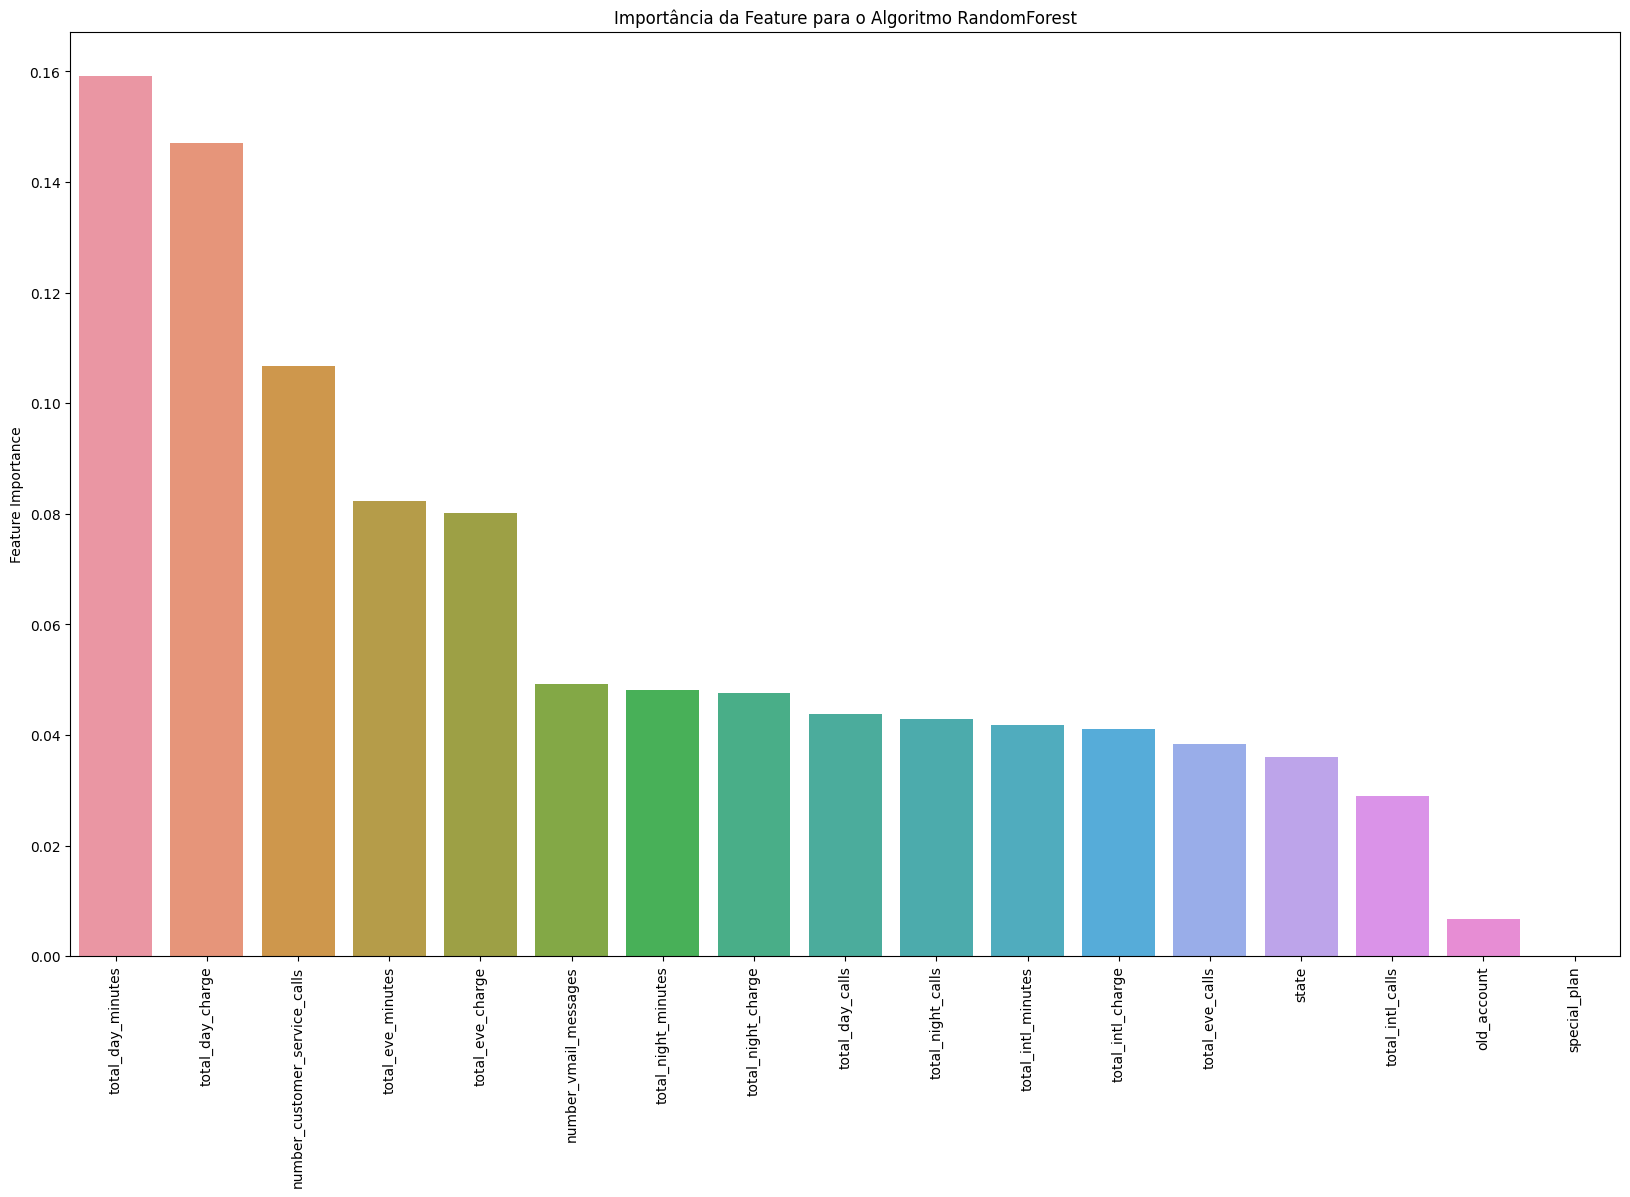

In [16]:
plt.figure(figsize=(20,12))
sns.barplot(data = plot, x=plot.index, y = 'Feature Importance')
plt.title('Importância da Feature para o Algoritmo RandomForest')
plt.xticks(rotation = 90);

As variáveis criadas na Engenharia de Atributos são as com menor importância. Elas serão removida do modelo. Pode-se testar se as variáveis originais são mais úteis na predição.

In [17]:
X_train, X_test = train_data.drop(columns = ['churn', 'special_plan', 'old_account']), \
                    test_data.drop(columns = ['churn', 'special_plan', 'old_account'])

In [18]:
train_n_score_model(modelo5, X_train, y_train, X_test, y_test)

Matriz de confusão

[[1442    1]
 [  66  158]]

               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1443
           1       0.99      0.71      0.83       224

    accuracy                           0.96      1667
   macro avg       0.97      0.85      0.90      1667
weighted avg       0.96      0.96      0.96      1667



Com as variáveis originais, o modelo alcançou 90% de F1 Score Macro.

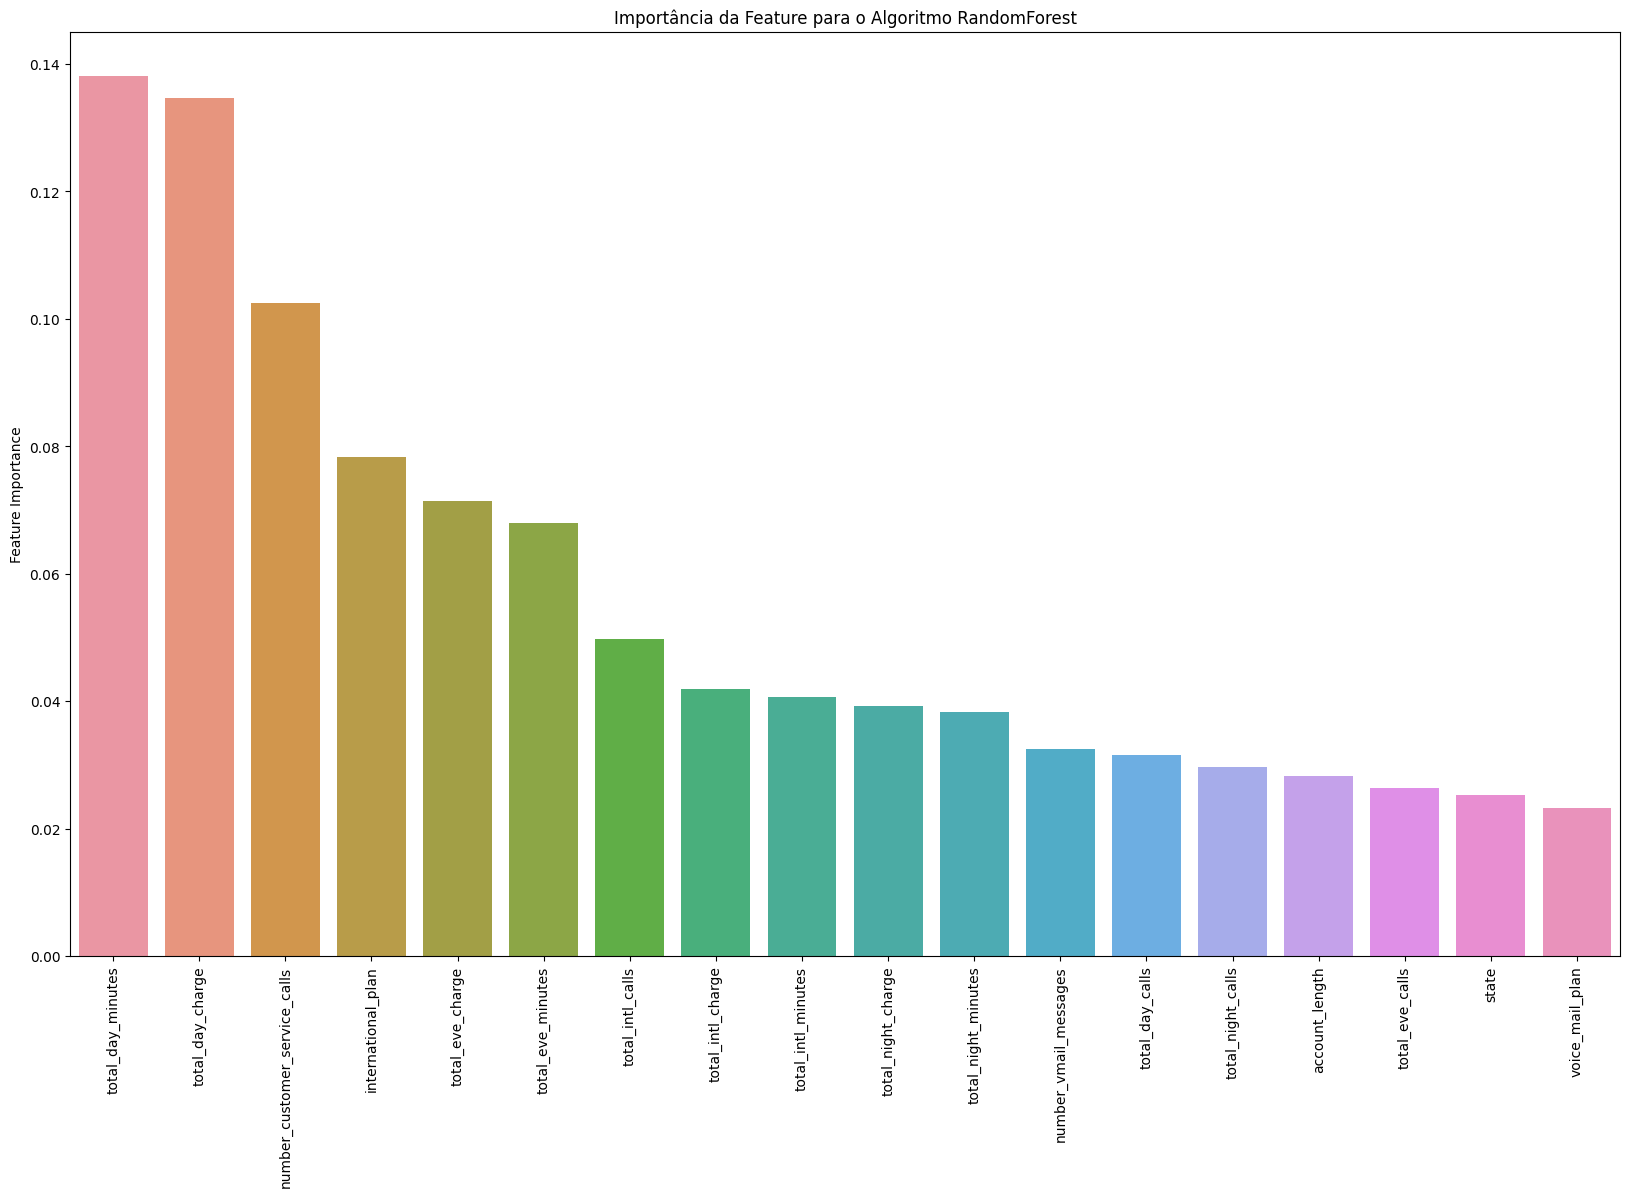

In [19]:
# Extrai a importância
feature_importance = modelo5.feature_importances_
feature_names = modelo5.feature_names_in_

# Dicionário de importâncias
importance_dict = {feature_names[i]: feature_importance[i] for i in range(len(feature_names))}

# Constrói um DataFrame a partir do dicionário
df_imp = pd.DataFrame(importance_dict, index=['Feature Importance'])

# Transpõe o Dataframe
df_imp = df_imp.T

# Mostra o resultado final
df_imp

# Objeto plot
plot = df_imp.sort_values(ascending=False, by=['Feature Importance'])

# Gráfico
plt.figure(figsize=(20,12))
sns.barplot(data = plot, x=plot.index, y = 'Feature Importance')
plt.title('Importância da Feature para o Algoritmo RandomForest')
plt.xticks(rotation = 90);

A variável international_plan é a quarta mais importante para as previsões, já a variável voice_mail plan é a segunda menos importante. Por hora, todas as variáveis serão mantidas no modelo.

## Modelo 6 - Random Forest com Otimização de Hiperparâmetros

In [20]:
# Criando um dicionário para o Grid-Search
param_grid = {'n_estimators': range(100, 600, 100),
              'criterion': ['gini', 'entropy'],
              'max_depth': range(4,10),
              'bootstrap': [True, False]}

# GridSearch
modelo6 = GridSearchCV(estimator= RandomForestClassifier(), 
                                  param_grid= param_grid,
                                  cv=5, 
                                  n_jobs=-1, 
                                  scoring='f1', 
                                  verbose=2)

In [21]:
train_n_score_model(modelo6, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Matriz de confusão

[[1440    3]
 [  68  156]]

               precision    recall  f1-score   support

           0       0.95      1.00      0.98      1443
           1       0.98      0.70      0.81       224

    accuracy                           0.96      1667
   macro avg       0.97      0.85      0.90      1667
weighted avg       0.96      0.96      0.95      1667



In [22]:
modelo6.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 9,
 'n_estimators': 400}

A otimização de hiperparâmetros não melhorou a performance do modelo. Pode-se testar outros algoritmos.

## Modelo 7 - XGBoost Classifier

In [23]:
modelo7 = XGBClassifier()

train_n_score_model(modelo7, X_train, y_train, X_test, y_test)

Matriz de confusão

[[1433   10]
 [  61  163]]

               precision    recall  f1-score   support

           0       0.96      0.99      0.98      1443
           1       0.94      0.73      0.82       224

    accuracy                           0.96      1667
   macro avg       0.95      0.86      0.90      1667
weighted avg       0.96      0.96      0.96      1667



O modelo XGBoost alcançou o F1 Score de 90%. Já chegou-se ao objetivo, mas pode-se tentar melhorar a performance do modelo ainda mais.

## Modelo 8 - XGBoost com parâmetro scale_pos_weight

O parâmetro scale_pos_weight é usado em casos de classes desbalanceadas para melhorar a performance do modelo. Seu valor ideal é o da proporção entre classe positiva e negativa.

In [24]:
classes = np.bincount(y_train)

In [25]:
modelo8 = XGBClassifier(scale_pos_weight = classes[0]/classes[1])

train_n_score_model(modelo8, X_train, y_train, X_test, y_test)

Matriz de confusão

[[1424   19]
 [  47  177]]

               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1443
           1       0.90      0.79      0.84       224

    accuracy                           0.96      1667
   macro avg       0.94      0.89      0.91      1667
weighted avg       0.96      0.96      0.96      1667



Com p parâmetro scale_pos_weight, o F1-Score aumentou em 1%.

## Modelo 9 - XGBoost com otimização de hiperparâmetros (GridSeach)

In [26]:
param_grid = {'max_depth': [3, 4, 5, 6, 7],
              'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
              'n_estimators': range(100,600,100),
              'gamma': [0, 0.1, 0.2]}

modelo9 = GridSearchCV(XGBClassifier(scale_pos_weight = classes[0]/classes[1]),
                                     cv = 5,
                                     param_grid = param_grid,
                                     n_jobs = -1,
                                     scoring = 'f1',
                                     verbose = 2)

train_n_score_model(modelo9, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 750 candidates, totalling 3750 fits
Matriz de confusão

[[1422   21]
 [  48  176]]

               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1443
           1       0.89      0.79      0.84       224

    accuracy                           0.96      1667
   macro avg       0.93      0.89      0.91      1667
weighted avg       0.96      0.96      0.96      1667



In [27]:
modelo9.best_params_

{'gamma': 0, 'learning_rate': 0.5, 'max_depth': 7, 'n_estimators': 100}

A otimização de hiperparâmetros não melhorou a performance do modelo. Por fim, serão testados mais 3 algoritmos.

## Modelo 10 - Naive Bayes

In [28]:
modelo10 = GaussianNB()

train_n_score_model(modelo10, X_train, y_train, X_test, y_test)

Matriz de confusão

[[1339  104]
 [ 108  116]]

               precision    recall  f1-score   support

           0       0.93      0.93      0.93      1443
           1       0.53      0.52      0.52       224

    accuracy                           0.87      1667
   macro avg       0.73      0.72      0.72      1667
weighted avg       0.87      0.87      0.87      1667



O Naive Bayes alcançou apenas 72% de F1-Score.

## Modelo 11 - KNN

In [29]:
k_list = [3,5,7,9]

for k in k_list:
    modelo11 = KNeighborsClassifier(n_neighbors = k)
    train_n_score_model(modelo11, X_train, y_train, X_test, y_test)

Matriz de confusão

[[1418   25]
 [ 170   54]]

               precision    recall  f1-score   support

           0       0.89      0.98      0.94      1443
           1       0.68      0.24      0.36       224

    accuracy                           0.88      1667
   macro avg       0.79      0.61      0.65      1667
weighted avg       0.86      0.88      0.86      1667

Matriz de confusão

[[1431   12]
 [ 190   34]]

               precision    recall  f1-score   support

           0       0.88      0.99      0.93      1443
           1       0.74      0.15      0.25       224

    accuracy                           0.88      1667
   macro avg       0.81      0.57      0.59      1667
weighted avg       0.86      0.88      0.84      1667

Matriz de confusão

[[1437    6]
 [ 194   30]]

               precision    recall  f1-score   support

           0       0.88      1.00      0.93      1443
           1       0.83      0.13      0.23       224

    accuracy                       

O melhor modelo KNN foi para k = 3. Porém mesmo assim o modelo teve apenas 65% de F1-Score.

## Modelo 12 - SVM Classifier

In [30]:
param_grid = {'C': [0.5, 1, 2],
              'kernel': ['rbf', 'linear'],
              'gamma': [0.01, 0.1, 1, 2]}

modelo12 = GridSearchCV(SVC(),
                         cv = 5,
                         param_grid = param_grid,
                         n_jobs = -1,
                         scoring = 'f1',
                         verbose = 2)

train_n_score_model(modelo12, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Matriz de confusão

[[1415   28]
 [ 150   74]]

               precision    recall  f1-score   support

           0       0.90      0.98      0.94      1443
           1       0.73      0.33      0.45       224

    accuracy                           0.89      1667
   macro avg       0.81      0.66      0.70      1667
weighted avg       0.88      0.89      0.88      1667



O SVM aparenta estar bastante enviesado. Suas métricas para a classe 1 estão bem baixas.

## Modelo 8 com threshold diferente de 0.5

Entre os modelos testados, o modelo 8 obteve a melhor performance. Agora, ao invés de optimizar hiperparâmetros, será testado a mudança do threshold. Serão usadas as previsões de probabilidades de classes e depois comparadas com diferentes valores de threshold para obter um novo conjunto de previsões.

In [31]:
# Lista de thresholds
thresh = [t/100 for t in range(5,100,5)]
thresh


[0.05,
 0.1,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7,
 0.75,
 0.8,
 0.85,
 0.9,
 0.95]

In [32]:
previsoes = []

preds_prob = modelo8.predict_proba(X_test)

temp = np.array([pred[0] for pred in preds_prob])


In [33]:
y_preds = [np.where(temp < t, 1, 0) for t in thresh]
y_preds

[array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 1, ..., 0, 0, 0])]

In [34]:
f1scores = [f1_score(y, y_test) for y in y_preds]

highestf1, highestf1index = max(f1scores), np.argmax(f1scores)

In [35]:
highestf1, highestf1index

(0.8486352357320098, 5)

In [36]:
print(confusion_matrix(y_preds[5], y_test))

[[1435   53]
 [   8  171]]


In [37]:
print(classification_report(y_preds[5], y_test))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1488
           1       0.76      0.96      0.85       179

    accuracy                           0.96      1667
   macro avg       0.88      0.96      0.91      1667
weighted avg       0.97      0.96      0.97      1667



O modelo com threshold de 0.3 obteve a melhor performance de F1-Score na validação cruzada. 

O F1-Score em teste foi o mesmo do modelo com threshold 0.5, porém a diferença está nas métricas de Precision e Recall. O modelo com threshold 0.5 obteve maior precision e menor recall, enquanto o modelo com threshold 0.3 obteve o contrário.

* **Precison** é mais importante quando quer se evitar Falsos Positivos.
* **Recall** é mais importante quando quer se evitar Falsos Negativos.

Considerando essa diferença, para o problema em questão, faz mais sentido obter um **Recall** maior, visto que um falso negativo, isto é, prever que um cliente não irá cancelar o serviço quando na realidade ele irá é mais prejudicial para o negócio do que prever que o cliente irá cancelar quando ele não irá.

# Conclusão

Com um modelo XGBoost Classifier, utilizando a otimização do hiperparâmetro scale_pos_weight e um threshold de 0.3, foi possível alcançar uma acurácia de 96%, com F1-Score de 91% e um recall de 96%.

**Mas o que isso significa para o negócio?**

Utilizando as previsões do modelo, o negócio seria capaz de prever o cancelamento de 171 dos 224 clientes que iriam cancelar o serviço, e então, usando estratégias de retenção, o churn poderia ser reduzido em até 75%.

